In [1]:
import pandas as pd

from util.sql_switch import get_query_native

count_query = "select count(ds.title), ds.title, ds.created_at \
from delab_moderationrating mr \
    join delab_moderationcandidate2 d on mr.mod_candidate_id = d.id \
    join delab_tweet dt on dt.id = d.tweet_id \
    join delab_simplerequest ds on dt.simple_request_id = ds.id \
where mr.u_moderating_part is not null \
  and mr.u_moderating_part <> '' \
group by \
    ds.title, ds.created_at \
order by count(ds.title) desc"

df_term_counts = get_query_native(count_query)
# print(df_term_counts.head(8))


# squashing similar titles
import functools as ft

list_of_similar_terms = [["Thema"], ["calm", "down"], ["constructive", "criticism"], ["explain", "view", "curious", "elaborate"], ["Meinung", "erläutern", "Ansicht"],
                         ["topic", "issue"], ["whataboutism"], ["valid", "point"], ["Perspektive"], ["agree", "common", "goal"], ["zustimmen", "gemeinsam", "Ziel"],
                         ["summary"], ["sachlich"], ["argument"], ["Argument"] ]

# list_of_similar_terms = []

def title_group_mapper(text):
    group_title = text
    for term_group in list_of_similar_terms:
        for term in term_group:
            if term in text and group_title == text:
                group_title = ft.reduce(lambda x, y: x + "_" + y, term_group)
    return group_title


grouped_titles = df_term_counts["title"].map(title_group_mapper)
df_term_counts["grouped_titles"] = grouped_titles
df_term_counts.drop(["title", "created_at"], axis=1, inplace=True)
df_term_counts = df_term_counts.groupby("grouped_titles").sum()
df_term_counts.sort_values(by=["count"], axis=0, inplace=True, ascending=False)
df_term_counts.head(10)

using postgres


/home/dehne/PycharmProjects/delab/venv/lib/python3.10/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,count
grouped_titles,
Thema,140
topic_issue,131
sachlich,128
explain_view_curious_elaborate,114
Meinung_erläutern_Ansicht,58
valid_point,40
constructive_criticism,32
whataboutism,29
"""entspann dich""",26


# Summary of biggest inter-coder conflicts

- load moderation rating from database or use previous
- show a list of top 10 conflicting ratings

In [2]:
import numpy as np

intercoder_query = "select dt.text, ds.created_at, ds.title, mr.u_moderating_part, mr.u_mod_rating as rating1, mr2.u_mod_rating as rating2, mr.mod_coder_id as coder_id_1, mr2.mod_coder_id as coder_id_2 \
from delab_moderationrating mr \
    join delab_moderationcandidate2 d on mr.mod_candidate_id = d.id \
    join delab_moderationrating mr2 on mr2.mod_candidate_id = d.id \
    join delab_tweet dt on dt.id = d.tweet_id \
    join delab_simplerequest ds on dt.simple_request_id = ds.id \
where mr.u_moderating_part is not null \
  and mr.u_moderating_part <> '' \
  and ds.created_at > '2022-09-01 00:00:00' \
  and mr.mod_coder_id <> mr2.mod_coder_id \
  and mr.u_mod_rating <> mr2.u_mod_rating;"

df_ic = get_query_native(intercoder_query)
df_ic.drop_duplicates("text", inplace=True)
grouped_titles = df_ic["title"].map(title_group_mapper)
df_ic["grouped_titles"] = grouped_titles
df_ic.drop("title", axis=1, inplace=True)


# print(df_ic.head(3))

def calculate_coding_distance(df):
    bigger = df.max(axis=1)
    smaller = df.min(axis=1)
    result = (bigger - smaller).abs()
    return result


df_ic["intercoder_distance"] = calculate_coding_distance(df_ic[["rating1", "rating2"]])
df_ic.sort_values(by="intercoder_distance", inplace=True, ascending=False)

df_ic.head(10)

using postgres


/home/dehne/PycharmProjects/delab/venv/lib/python3.10/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,text,created_at,u_moderating_part,rating1,rating2,coder_id_1,coder_id_2,grouped_titles,intercoder_distance
353,"@UltraXBT Would love to hear your view on #CB, the project looks solid and have been catching many eyes lately, low mc, low tax of 7% and their Dapp is releasing soon\n\n#CB $CB #BTC #ETH @thecloutbase https://t.co/xw6qEnA5RI",2022-11-17 10:50:52.533139+00:00,"Would love to hear your view on #CB, the project looks solid and have been catching many eyes lately, low mc, low tax of 7% and their Dapp is releasing soon #CB $CB #BTC #ETH @thecloutbase",2,-2,11,1,explain_view_curious_elaborate,4
29,@alcesmoose @ZDFheute wie mich solche Kommentare nerven! Bleib beim Thema. Opferschutz vor Täterschutz! Klare Sache.,2022-11-15 09:13:42.645863+00:00,Bleib beim Thema.,2,-2,11,1,Thema,4
32,"@kkklawitter Frau, du musst nicht jeden Artikel hochholen und eine Forderung daraus machen. Ich habe drei Kinder, alle im Kindergarten, alle an der Hauptstraße, doof aber OK. Der Tod des Mädchen ist tragisch. Aber bitte benutze sowas nicht für deinen Sendungsdrang. Bleib beim Thema...",2022-11-15 09:13:42.645863+00:00,Bleib beim Thema...,2,-2,11,1,Thema,4
225,"@alex13wetter @wfritz56 @AndiFrankfurt @happy_smile4you Könnt ihr jetzt bitte mal beim Thema bleiben ? Was ist Euer Hobby außer : saufen, schlagen und SGE ?",2022-11-22 08:32:31.608921+00:00,Könnt ihr jetzt bitte mal beim Thema bleiben ?,2,-2,11,1,Thema,4
36,"@luebberding Das ist auch ein guter Punkt. 🙃 Die Verflechtungen der chinesischen Wirtschaft sind hier bei uns recht unbekannt (auch Singapur, selbst Kalifornien sollten eigentlich sicher sein). Die Zerstörung Taiwans dürfte im Chip-Bereich für China verheerender sein als jede US-Sanktion.",2022-11-14 13:29:39.444238+00:00,Das ist auch ein guter Punkt.,2,-2,11,1,"""guter Punkt""",4
37,@OfficialTravlad @OfficialTravlad can u pls explain further cos I really don’t understand what this mean,2022-11-14 14:46:06.202107+00:00,can u pls explain further cos I really don’t understand what this mean,2,-2,11,1,explain_view_curious_elaborate,4
356,"Können wir uns vielleicht einfach darauf einigen, dass jeder versucht seinen Teil beizutragen und man sich diese traurigen, moralinsauren Belehrungen spart?",2022-11-28 15:49:56.739324+00:00,"Können wir uns vielleicht einfach darauf einigen, dass jeder versucht seinen Teil beizutragen und man sich diese traurigen, moralinsauren Belehrungen spart?",2,-2,11,1,"uns ""darauf einigen""",4
410,"@SaFnE72 @LadwigHelga @haru_thebear @SaBu78424919 @Elmal96 Entspann dich, lass es fließen, du willst schon wieder alles zu schnell, es soll Spaß machen und keinen Frust 😘😘😘",2022-12-07 10:31:44.608164+00:00,"@SaFnE72 @LadwigHelga @haru_thebear @SaBu78424919 @Elmal96 Entspann dich, lass es fließen, du willst schon wieder alles zu schnell, es soll Spaß machen und keinen Frust 😘😘😘",2,-2,1,11,"""entspann dich""",4
131,"@PaulRTownsend @dayoconnor1930 Your comments made me reflect a bit, so I'm going to do the unthinkable and post a screenshot of my thoughts instead of creating a 20 tweet thread (poor Twitter etiquette, I know!) Always appreciate the feedback Paul, which I hope comes through in my response https://t.co/OUNrxIa35N",2022-11-17 10:33:50.514645+00:00,"Always appreciate the feedback Paul, which I hope comes through in my response",2,-2,11,1,appreciate feedback,4
130,"@NickG972 My family was directly affected by the Race Massacre on Black Wall Street, my uncle was murder and hung by the KKK in the 90's. Can you understand why racism is deal breaker with me? Like you said we all have the freedom to think what we want. And some of us have experiences.",2022-11-17 10:10:10.968562+00:00,Can you understand why racism is deal breaker with me?,2,-2,11,1,"""can you understand""",4


# Summary of inter-coder-reliability over time and per phrases
- load the dataset from the db
- set 2 to 1, and -2 to -1 for simplicity
- compute Krippendorf-Alpha for the ratings
- plot Krippendorf-Alpha over time globally
- plot Krippendorf-Alpha over time per title

In [3]:
import simpledorff

inter_coder_reliability_query = "select ds.created_at, ds.title, mr.u_mod_rating, mr.mod_coder_id \
from delab_moderationrating mr \
    join delab_moderationcandidate2 d on mr.mod_candidate_id = d.id \
    join delab_tweet dt on dt.id = d.tweet_id \
    join delab_simplerequest ds on dt.simple_request_id = ds.id \
where mr.u_mod_rating <> 0"

df_rel_org = get_query_native(inter_coder_reliability_query)
df_rel = df_rel_org
grouped_titles = df_rel["title"].map(title_group_mapper)
df_rel["grouped_titles"] = grouped_titles
df_rel.drop("title", axis=1, inplace=True)

value_mapping = {2: 1, -2: -1}
coder_mapping = {1: 1}
for i in range(2, 100):
    coder_mapping[i] = 2
df_rel.replace({"mod_coder_id": value_mapping}, inplace=True)
df_rel.replace({"mr.mod_coder_id": coder_mapping}, inplace=True)
# create new time_stamp_column that takes a time_stamp every 10 units per topic
df_rel["created_at"] = df_rel["created_at"].map(lambda x: pd.to_datetime(x))
df_rel.sort_values(by="created_at", inplace=True)
df_rel.set_index("created_at", inplace=True)


def compute_incremental_krippendorf_column(df):
    df = df.copy(deep=True)
    date2krippendorf = {}

    # debugging code
    if "valid_point" in list(df.grouped_titles):
        print("testing incremental krippendorf")
    if "Sichtweise" in list(df.grouped_titles):
        print("testing krippendorf 0")
    if "sachlich" in list(df.grouped_titles):
        print("testing krippendorf sachlich")

    week_labels_list = []
    for week_index, weekly_labels in df.groupby(pd.Grouper(freq="3D")):
        try:
            week_labels_list.append(weekly_labels)
            week_labels_aggro = pd.concat(week_labels_list)
            s_dorf = simpledorff.calculate_krippendorffs_alpha_for_df(week_labels_aggro, experiment_col='created_at',
                                                                      annotator_col='mod_coder_id',
                                                                      class_col='u_mod_rating')
        except ZeroDivisionError:
            s_dorf = np.NaN

        for date in weekly_labels.index:
            date2krippendorf[date] = s_dorf

    pd.options.mode.chained_assignment = None
    df["krippendorf"] = df.index.map(date2krippendorf)
    return df


# compute the krippendorf for each title_group
krippendorfed_frames = []

for title in set(df_rel.grouped_titles):
    single_title_dataset = df_rel[df_rel["grouped_titles"] == title]
    df_rel_single_with_krippendorf = compute_incremental_krippendorf_column(single_title_dataset)
    krippendorfed_frames.append(df_rel_single_with_krippendorf)

df_rel_with_krippendorf = pd.concat(krippendorfed_frames)
# printing out the codings from the last day and their incremental krippendorf (aggregated over all weeks)
print(df_rel_with_krippendorf.last("1D"))

using postgres


/home/dehne/PycharmProjects/delab/venv/lib/python3.10/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


testing incremental krippendorf
testing krippendorf sachlich
testing krippendorf 0
                                  u_mod_rating  mod_coder_id  \
created_at                                                     
2022-07-27 11:57:16.328895+00:00             1             1   
2022-07-27 11:57:16.328895+00:00            -2            11   
2022-07-27 11:57:16.328895+00:00            -2             9   
2022-07-27 11:57:16.328895+00:00            -2             1   
2022-07-27 11:57:16.328895+00:00            -2             9   
...                                        ...           ...   
2022-07-12 10:26:52.284849+00:00            -1             9   
2022-07-12 10:26:52.284849+00:00            -2             9   
2022-07-12 10:26:52.284849+00:00            -2             1   
2022-07-12 10:26:52.284849+00:00            -2             1   
2022-07-12 10:26:52.284849+00:00            -2             9   

                                          grouped_titles  krippendorf  
created_at  

### Summary of best working Terms:
- sorted by the highest krippendorf at the current time aggregating all data
- grouped by the phrases

In [4]:
df_rel_highest_icr = df_rel_with_krippendorf.groupby("grouped_titles").last()
df_rel_highest_icr = df_rel_highest_icr.drop(["u_mod_rating", "mod_coder_id"], axis=1)
df_rel_highest_icr = df_rel_highest_icr[df_rel_highest_icr["krippendorf"] != 0]
df_rel_highest_icr.sort_values(by="krippendorf", inplace=True, ascending=False)


# computed the krippendorf column
# listing the highest icr by grouped_title
df_rel_highest_icr.head(10)

,krippendorf
grouped_titles,
calm_down,0.509434
valid_point,0.466463
constructive_criticism,0.266667
agree_common_goal,0.259259
topic_issue,0.246377
Meinung_erläutern_Ansicht,0.200000
explain_view_curious_elaborate,0.193333
Thema,0.085185
"""can you respond""",NaN


In [5]:
#calculate overall average of krippendorf
df_rel_2 = df_rel_org
s_dorf = simpledorff.calculate_krippendorffs_alpha_for_df(df_rel_2, experiment_col='created_at',
                                                          annotator_col='mod_coder_id',
                                                          class_col='u_mod_rating')
s_dorf

0.2513227513227514

# Computing Time Sliced Development of Krippendorf

- write procedure to slice the dataframe in time spans of a week
- calculate the krippendorf per title group and week (if possible)
- plot the changes in krippendorf over time


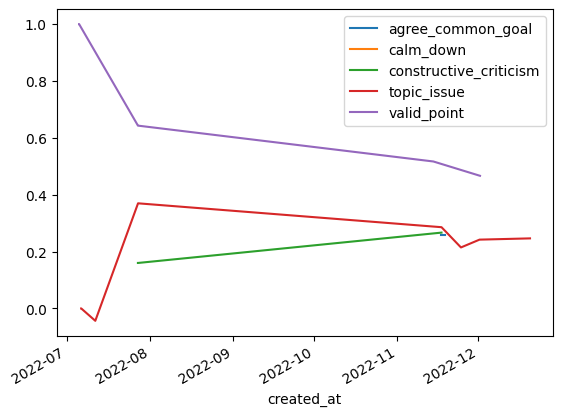

In [6]:
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt

top_5_titles = df_rel_highest_icr.head(5)
df_rel_top_5 = df_rel_with_krippendorf[df_rel_with_krippendorf["grouped_titles"].isin(top_5_titles.index.to_list())]
#df_rel_top_5.reset_index(inplace=True)

fig, ax = plt.subplots()

for key, grp in df_rel_top_5.groupby(['grouped_titles']):
    if grp.empty:
        print('DataFrame is empty for title {}!'.format(key))
    if grp[grp["krippendorf"] > 0].empty:
        print('Alle 0 für {}!>'.format(key))
    ax = grp.plot(ax=ax, kind='line', y='krippendorf', label=key)
#ax.set_xlim([datetime.date(2022, 9, 15), datetime.date(2023, 1, 1)])
plt.legend(loc='best')
plt.show()
